# Install libraries

In [ ]:
!pip install qiskit --quiet
!pip install git+https://github.com/oseledets/ttpy.git --quiet
!sed --i -e 's/np.object/object/g' /usr/local/lib/python3.10/dist-packages/tt/multifuncrs.py
!sed --i -e 's/np.object/object/g' /usr/local/lib/python3.10/dist-packages/tt/multifuncrs2.py
!sed --i -e 's/np.complex/complex/g' /usr/local/lib/python3.10/dist-packages/tt/core/vector.py
!sed --i -e 's/np.complex/complex/g' /usr/local/lib/python3.10/dist-packages/tt/core/matrix.py
!sed --i -e 's/np.float/float/g' /usr/local/lib/python3.10/dist-packages/tt/core/vector.py
!sed --i -e 's/np.int/int/g' /usr/local/lib/python3.10/dist-packages/tt/optimize/tt_min.py
!pip install pylatexenc --quiet
!pip install --upgrade numpy==1.23

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit import BasicAer, execute

# Ningyi's IPA implementation for the 1D double well model

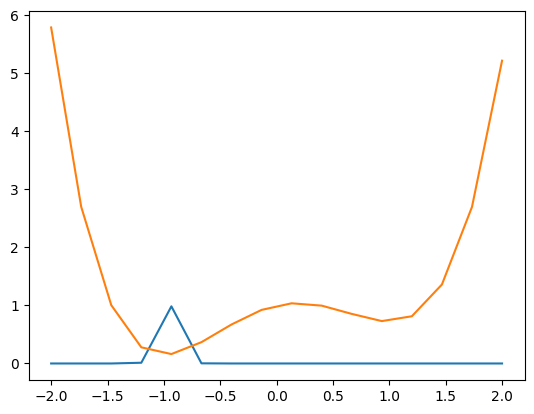

In [ ]:
"""
Created on Sat Jul 16 14:52:30 2022

@author: Ningyi Lyu
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit import Aer, execute
from qiskit.extensions import RXGate, XGate, CXGate
beta=5.
nsc=4
n=16
om=1
m=1
#x=np.linspace(-5,5,n)+1/3
x=np.linspace(-2,2,n)

#PES for 1D HO
#def v(x):
#    out=0.5*m*om*x**2
#    return out

#PES for 1D double well with DNA parameters
def v(x):
    out=0.429*x-1.126*x**2-0.143*x**3+0.563*x**4+1
    return out
#Grid PES
vgrid=np.zeros(n)
for i in range(n):
    vgrid[i]=v(x[i])
# Initial uniform distribution
psi0=np.ones(n)/LA.norm(np.ones(n))
vmat=np.diag(vgrid)

#IPA matrix
G=LA.expm(-beta*vmat)
psi=psi0
for i in range(nsc):
    psi=G@psi
    psi=psi/LA.norm(psi)
#Dilation process. np.sqrt is essentially carrying out by SVD and square rooting the singular values.
UG=np.block([[G,np.sqrt(np.eye(n)-G@np.transpose(np.conjugate(G)))],[np.sqrt(np.eye(n)-np.transpose(np.conjugate(G))@G),-np.transpose(np.conjugate(G))]])
U_gate=Operator(UG)

#quantum simulation with qiskit
M_simulator=Aer.backends(name='qasm_simulator')[0]
vector_init=np.append(np.ones(n)*np.sqrt(1/n),np.zeros(n))
vector=vector_init
for i in range(nsc):
    circuit=QuantumCircuit(5,5)
    circuit.initialize(vector)
    circuit = transpile(circuit, basis_gates=["u3","u2","u1","cx","id","u0","u","p","x","y","z","h","s","sdg","t","tdg","rx","ry","rz","sx","sxdg","cz","cy","swap","ch","ccx","cswap","crx","cry","crz","cu1","cp","cu3","csx","cu","rxx","rzz","rccx","rc3x","c3x","c3sqrtx","c4x"])
    circuit.append(U_gate,[0,1,2,3,4])
    circuit.measure(0,0) # measure the first qubit and record it in the first classical bit
    circuit.measure(1,1) # measure the second qubit and record it in the second classical bit
    circuit.measure(2,2)
    circuit.measure(3,3)
    circuit.measure(4,4)
    job = M_simulator.run(circuit, shots=2000)
    hist=job.result().get_counts()
    ind_list=['{:05b}'.format(x) for x in range(32)]
    vector=np.zeros(2*n)
    for j in range(n):
        if hist.get(ind_list[j])==None:
            vector[j]=0
        else:
            vector[j]=hist.get(ind_list[j])
    vector=vector/np.sum(vector)
    vector=np.sqrt(vector)
#Visualizing the results
density=vector*vector
density=density[0:16]
plt.plot(x,density)
plt.plot(x,vgrid)


# Implementation in the Fock basis

#### Install qutip

In [ ]:
!pip install qutip
import qutip as qt
from qutip import *
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import Image

from pylab import *
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

import imageio
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
from matplotlib import cm, animation
from mpl_toolkits.mplot3d import Axes3D
from base64 import b64encode
from IPython.display import HTML

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100

import numpy as np
import qutip as qt
from qutip import about, basis, destroy, mesolve, ptrace, qeye, tensor, wigner, Qobj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 74.1 MB/s eta 0:00:00


#### Propagation in the Fock representation

In [ ]:
xmin = -5.5
xmax = 5.5
N = 2**5

dp = 2.0*np.pi/(xmax-xmin)
pv=np.arange(-N/2,N/2)*dp
dx=(xmax-xmin)/N*0.5
xvec=np.arange(-N/2,N/2)*dx

# Conversion of Fock state to coord representation by inverse Wigner transform
def F2C(fockstate):
  wt=wigner(fockstate,xvec/2,pv)
  out=np.zeros(np.size(xvec),dtype=complex)
  for k in range(np.size(xvec)):
    for j in range(np.size(pv)):
      out[k]+=dp*np.exp(1j*pv[j]*xvec[k])*wt[j,k]
  fo=np.sqrt(norm(out)**2*dx)
  return out/fo

# Conversion from Fock to coord representation
def qpsi(f,nn):
  out=f[0]*fock(nn,0)
  for j in range(1,nn):
    out+=f[j]*fock(nn,j)
  out = F2C(out)
  return out

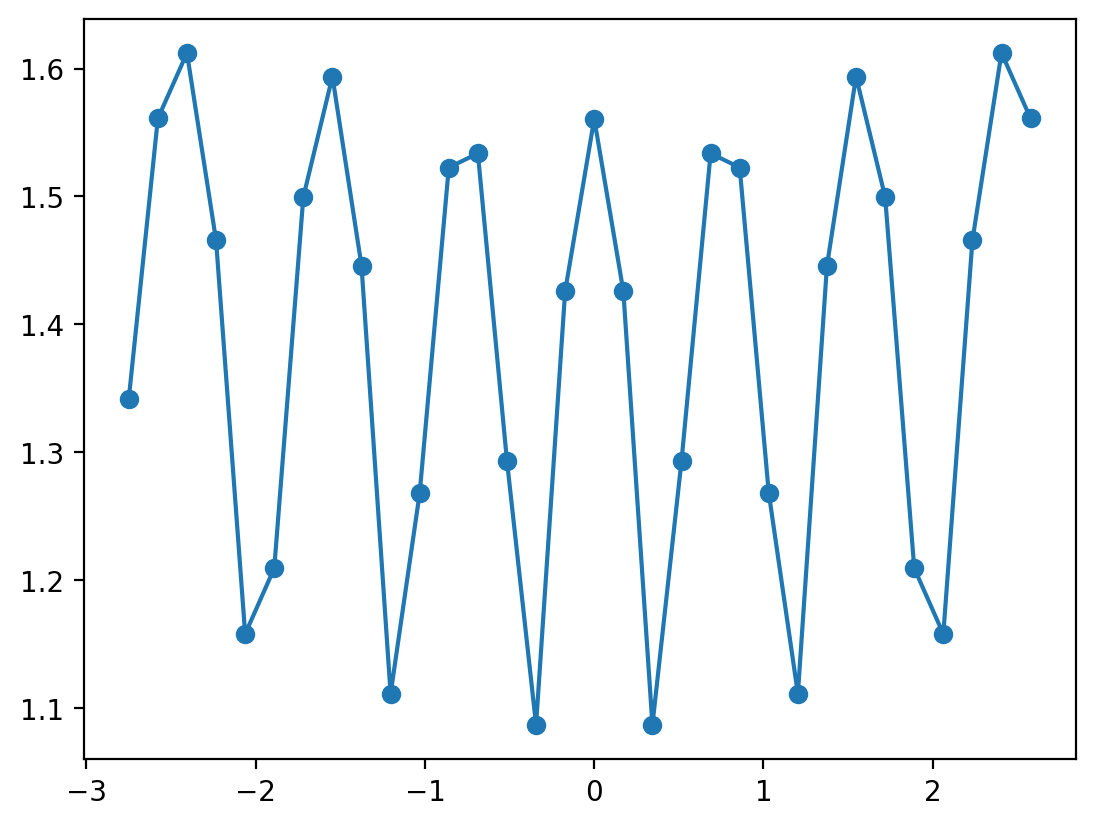

In [ ]:
Nf=N
psi_test=fock(Nf,8)
psi_test=psi_test.full()
psi_test=psi_test.flatten()
psix_test=qpsi(psi_test,Nf)
plot(xvec,1+np.abs(psix_test),'-o')

In [ ]:
import scipy.linalg as la

xo = 0.75
po = 1.75

Nf=2**5                                                         # Define # of states to include in basis
a = qt.destroy(Nf)                                               # Define annihilation operator
n = qt.num(Nf)                                                   # Define number operator
x = (a + a.dag())/np.sqrt(2.0)                                  # position operator in terms of creation and annihilation operators
p = -1.j * (a - a.dag())/np.sqrt(2.0)                           # momentum operator in terms of creation and annihilation operators

def V(x):
  out=0.429*x-1.126*x**2-0.143*x**3+0.563*x**4+1
  return out

m = 1                                              # mass = 1.0
#ham=p**2/(2*m)+V(x)
ham=V(x)

psi = qt.coherent(Nf, alpha=(xo+(po*1j))/np.sqrt(2))            # Define a coherent state with amplitude alpha
psi=psi.full()
psi=psi.flatten()

tfinal=10
dt=5
nsteps=int(tfinal/dt)
tlist = np.linspace(0, tfinal, nsteps)  # Define the list of times for which we calculate dynamics.
tau = tlist[1]-tlist[0]

ham=ham.full()
Um=la.expm(-ham*tau)

# Propagator for Fock representation
result=[np.asarray(psi)]
for i in range(10):
  psi=np.dot(Um,psi)
  psi/=norm(psi)
  result.append(np.asarray(psi))

In [ ]:
result[0].shape

(32,)

In [ ]:
wxw=qt.coherent(Nf, alpha=(xo+(po*1j))/np.sqrt(2))
np.asarray(wxw).shape

(32, 1)

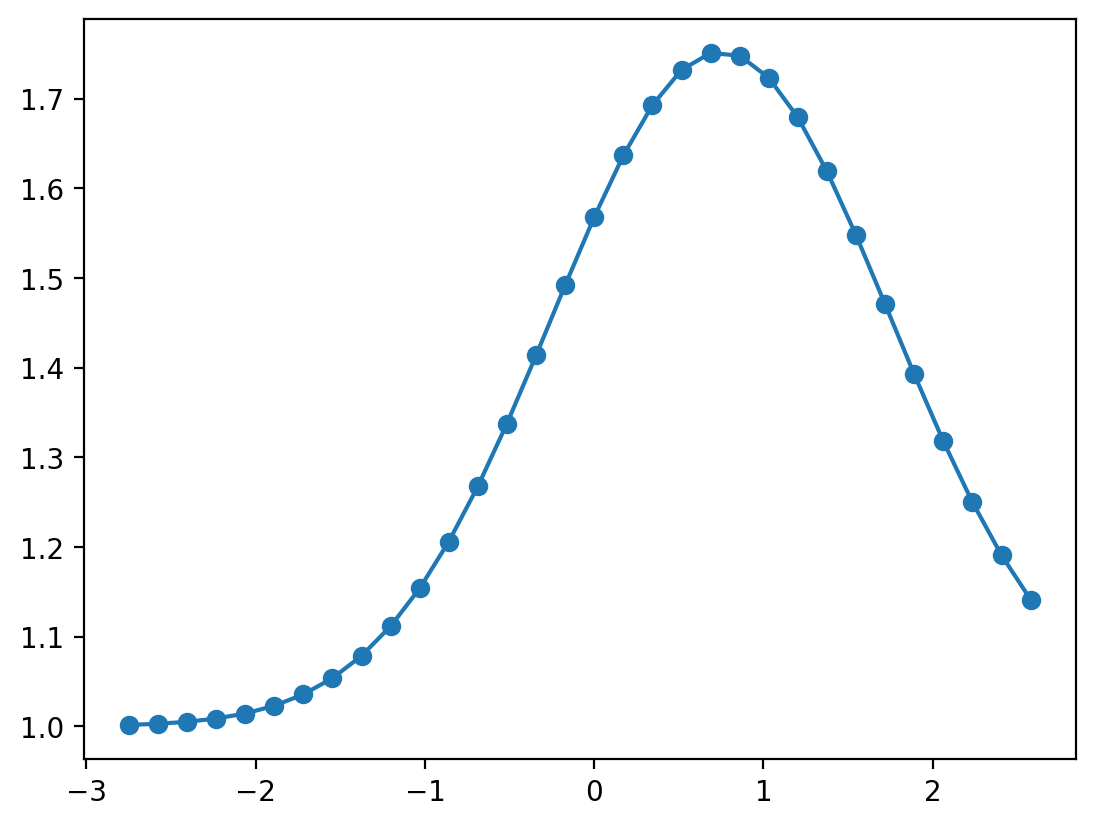

In [ ]:
psio=qt.coherent(Nf, alpha=(xo+(po*1j))/np.sqrt(2))
psio=psio.full()
psio=psio.flatten()
psiox=qpsi(psio,Nf  )
plot(xvec,1+np.abs(psiox),'-o')

###### Plot of $\psi(x)$

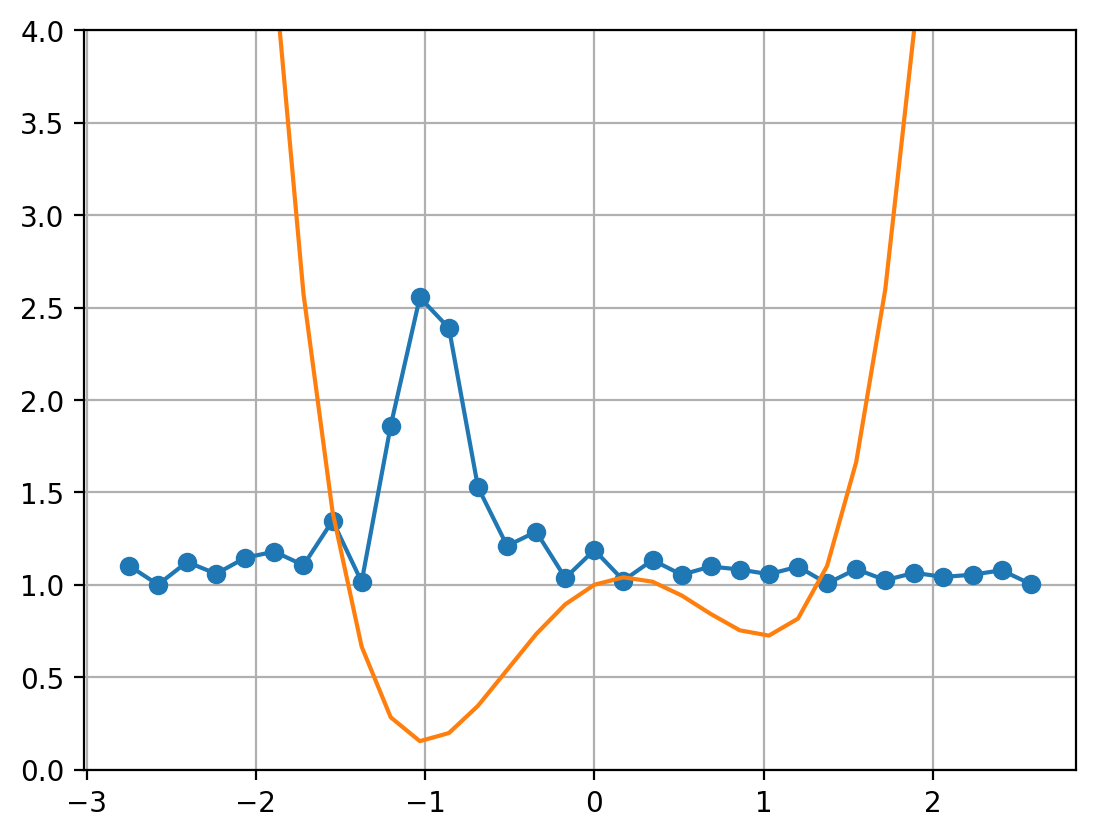

In [ ]:
plot(xvec,1+np.abs(qpsi(result[nsteps],Nf)),'-o')
#ref=np.exp(-(xvec-xo)**2/2+1j*po*xvec)/(np.pi)**0.25
#plot(xvec,np.real(ref),'-')
plot(xvec,V(xvec),'-')
ylim(0,4)
grid()